In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
import setproctitle
from opt import config_parser
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import setproctitle
import tqdm 
from utils.general import * 
parser = config_parser()
args = parser.parse_args()

device = torch.device("cuda:1")
args.archCNN = 'resnet34'

det = args.det
lindisp = args.lindisp
args.distributed = False
args.local_feature_ch = 512
args.local_rank = 1
args.eval_scene = 'cars'
args.eval_dataset = 'srns_dataset'
args.num_local_layers = 2
args.no_load_opt = True
args.no_load_scheduler = True


args.enforce_symmetry = {'status':False,
                         'on_coarse':False,'on_fine':False,
                         'concatenate_on_coarse':False, 'concatenate_on_fine':False}
args.use_deepLabv3 = True
args.module_with_cosine = {'use':False,'G':16}

setproctitle.setproctitle('[Gaetan - DeepLabV3 encoder]')

In [4]:
cd "/root/SymmNeRF-baseline/code"

/root/SymmNeRF-baseline/code


In [5]:
from model.model import HyperNeRFResNetSymmLocal 
args.use_deepLabv3 = True
model_deepV3 = HyperNeRFResNetSymmLocal(args,ckpts_folder = '')
args.use_deepLabv3 = False 
model_resnet = HyperNeRFResNetSymmLocal(args,ckpts_folder = '') 

[INFO] Using HyperNetworks to generate the weights of the NeRF. [INFO]
[INFO] Using DeepLabV3 as CNN feature extractor. [INFO]
[Info] No ckpts found, training from scratch...
[INFO] Using HyperNetworks to generate the weights of the NeRF. [INFO]
[Info] No ckpts found, training from scratch...


In [7]:
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 

bs = 2

train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset,batch_size = bs , sampler = train_sampler,shuffle=True)

[Info] Training dataset: srns_dataset
[Info] Loading SRNs dataset: /data/srn_cars/cars_train


In [8]:
from model.sample_ray import RaySampler
from utils.general import cycle

# Get another iteration on the Dataloader
it = iter(train_loader)
train_batch = it.next()

# RaySampler class instantiation.
ray_sampler = RaySampler(train_batch) 

# Number of rays and number of points sampled alogn each ray.
nb_rays = 64
nb_sampled_points_on_rays = 256

# Build up a batch of ray. 
ray_batch = ray_sampler.random_sample(nb_rays,use_bbox = True,device = device)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


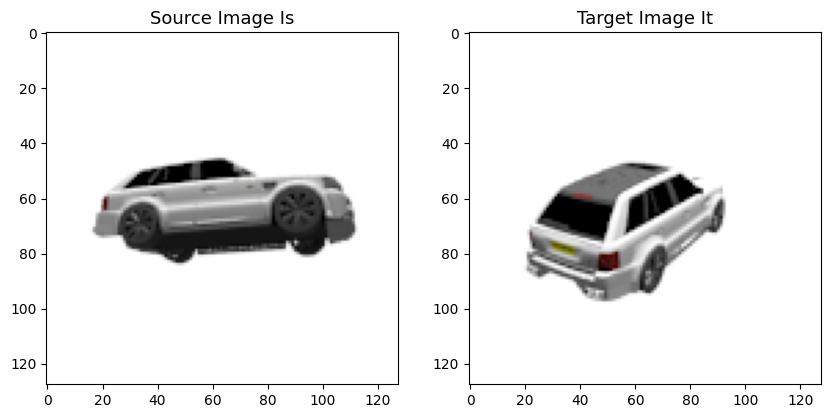

In [9]:
### Print out the source and target image we considering. (lets say the first image of the batch)
import matplotlib.pyplot as plt
import torch 
import numpy as np 
import cv2

H,W = 128,128
img_tot_pix = H*W
selected_ray = np.random.randint(nb_rays)


# Source image.
src_img = torch.permute(ray_batch['src_img'][0,:],(1,2,0)).cpu().numpy()

# Target one.
idx_tgt_img = ray_batch['pixs'][0][...,0][selected_ray]   # [0] for the first instance of the batch - [...,0] to get all the images index that were sampled. - [selected_ray] the selected ray 
tgt_img_flatten = ray_sampler.rgb_gt[0][img_tot_pix*idx_tgt_img:img_tot_pix*idx_tgt_img+img_tot_pix]
tgt_img = torch.reshape(tgt_img_flatten,(H,W,3)).cpu().numpy()

## Plot.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(src_img)
ax2.imshow(tgt_img)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)

plt.show()


#### Get the feature 

In [10]:
z_deep = model_deepV3.encode(ray_batch['src_img'])
z_resnet = model_resnet.encode(ray_batch['src_img'])

In [11]:
from model.render_ray import sample_along_camera_ray

rays_o = ray_batch['rays_o']    # [B,256,3]
rays_d = ray_batch['rays_d']    # [B,256,3]
z_near = ray_batch['z_near']
z_far = ray_batch['z_far']

noise = False 

#### 1. Get the 3D points ray, the viewdir and z sampled dist.
pts, viewdirs, z_vals = sample_along_camera_ray(rays_o=rays_o,  # pts : [B,256,64,3] - viewdirs : [B,256,3] - z_vals : [B,256,64]
                                                rays_d=rays_d,
                                                z_near=z_near,
                                                z_far=z_far,
                                                device=device,
                                                N_samples=nb_sampled_points_on_rays,
                                                lindisp=lindisp, 
                                                det=det)


#### 2. Get the sampled features (from the F and the source RGB image) 
ret_deep = model_deepV3.feature_net.index(pts,ray_batch)
ret_resnet = model_resnet.feature_net.index(pts,ray_batch)

### Compare the in raw2outputs() the way dists variable is build() 

In [30]:
### In SymmNeRF 
dists_SymmNeRF = z_vals[..., 1:] - z_vals[..., :-1]
dists_SymmNeRF = torch.cat([dists_SymmNeRF, torch.Tensor([1e10]).expand(dists_SymmNeRF[..., :1].shape).to(device)], -1)  # [batch,N_rays, N_samples]
dists_SymmNeRF = dists_SymmNeRF * torch.norm(rays_d[..., None, :], dim=-1)

### In VisionNeRF
dists_Vision = z_vals[..., 1:] - z_vals[..., :-1]
dists_Vision = torch.cat((dists_Vision, dists_Vision[..., -1:]), dim=-1)

In [40]:
print(f'Shape of dists_SymmNeRF: {dists_SymmNeRF.shape}')
print(f'Shape of dists_Vision: {dists_Vision.shape}')

selected_ray = np.random.choice(64)

dist_first_ray_SymmNeRF = dists_SymmNeRF[0,selected_ray,:].cpu().numpy()
dist_first_ray_Vision = dists_Vision[0,selected_ray,:].cpu().numpy()

plt.figure()
plt.scatter([i for i in range(255)],dist_first_ray_SymmNeRF[:-1],color='r')
plt.scatter([i for i in range(256)],dist_first_ray_Vision,color='g')

plt.show()


NameError: name 'dists_SymmNeRF' is not defined

In [5]:
hasattr(model, 'hypernetwork')

NameError: name 'model' is not defined